## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. 

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" & landing_page == "old_page"')['converted'].count()+ df.query('group == "control" & landing_page == "new_page"')['converted'].count()

3893

In [7]:
# for cross checking above answer
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

g. How long the experiment was done?

In [9]:
# Conversting datatype of 'timestamp' parameter ti datetime from object
df.timestamp = pd.to_datetime(df.timestamp)

In [10]:
# Checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [11]:
# Calculating how long the experiment was run
max(df.timestamp)-min(df.timestamp)

Timedelta('21 days 23:59:49.081927')

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
df2 = df.drop(df[(df.group=="treatment") & (df.landing_page=='old_page')].index)
df2.drop(df2[(df2.group=="control") & (df2.landing_page=='new_page')].index, inplace = True)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [14]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
df2[df2.duplicated(['user_id'], keep=False)].loc[:,'user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [16]:
# Alternate way
df2[df2.duplicated(['user_id'], keep=False)].iloc[0,0]

773192

c. What is the row information for the repeat **user_id**? 

In [17]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
df2.drop_duplicates(['user_id'], keep = 'first', inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
prob_converted = df2.query('converted == 1')['converted'].count()/df2.converted.count()
prob_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
# prob_converted_given_control = prob_converted_and_control / prob_control
# Conditional probability
prob_control = df2.query('group == "control"')['group'].count()/df2.converted.count()
prob_converted_and_control = df2.query('group == "control" & converted == 1')['group'].count()/df2.converted.count()
prob_converted_given_control = prob_converted_and_control / prob_control
prob_converted_given_control

0.12038630450046119

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
# prob_converted_given_treatment = prob_converted_and_treatment / prob_treatment
# Conditional probability
prob_treatment = df2.query('group == "treatment"')['group'].count()/df2.converted.count()
prob_converted_and_treatment = df2.query('group == "treatment" & converted == 1')['group'].count()/df2.converted.count()
prob_converted_given_treatment = prob_converted_and_treatment / prob_treatment
prob_converted_given_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
prob_new_page = df2.query('landing_page=="new_page"')['landing_page'].count()/df2.landing_page.count()
prob_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer:**

>a. The overall probability of an individual converting regardless of the page they receive = 0.11959708724499628
>
>b. The probability of an individual converting if they are from control group = 0.12038630450046119
>
>c. The probability of an individual converting if they are from treatment group = 0.11880806551510564
>
>d. The probability that an individual received the new page = 0.5000619442226688

>As the probability of an individual receiving new_page is 0.5, we can say that the dataset is unbiased which means there are almost equal number of individuals in control and treatment group.
>
>From observations in a, b, c we can say that the conversion rate in control group and treatment group is approximately equal to the overall conversion rate which is approximately 0.12.
Hence, there is no sufficient evidence to say that the new treatment page leads to more conversions.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**

>Null Hypothesis H0: **$p_{new}$** <= **$p_{old}$** 
>
>Alternative Hypothesis H1: **$p_{new}$** > **$p_{old}$** 
>
>Type I error rate(alpha) = 0.05

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
# From the given assumpsion under the null hypothesis
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
# From the given assumpsion under the null hypothesis
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1- p_new), p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

In [28]:
(new_page_converted==1).mean()

0.12067304383731332

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1- p_old), p_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

In [31]:
(old_page_converted==1).mean()

0.11969795008053746

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [32]:
(new_page_converted==1).mean() - (old_page_converted==1).mean()

0.0009750937567758605

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [33]:
p_diffs = []
a=[0,1]
for i in range(10000):
    new_page_converted = np.random.choice(a, size=n_new, p=[(1- p_new), p_new])
    old_page_converted = np.random.choice(a, size=n_old, p=[(1- p_old), p_old])
    p_diffs.append((new_page_converted==1).mean() - (old_page_converted==1).mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

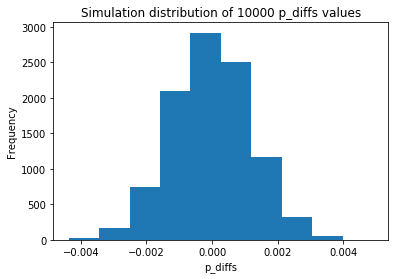

In [34]:
plt.xlabel("p_diffs")
plt.ylabel("Frequency")
plt.title("Simulation distribution of 10000 p_diffs values")
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [35]:
# Actual difference observed in ab_data.csv
actual_p_new= df2.query('landing_page == "new_page"')['converted'].mean()
actual_p_old= df2.query('landing_page == "old_page"')['converted'].mean()
actual_p_diff= actual_p_new - actual_p_old
actual_p_diff

-0.0015782389853555567

In [36]:
(p_diffs > actual_p_diff).mean()

0.9041

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

>In part j, I have computed the probability of obtaining observed statistics from given dataset considering null hypothesis is true. This is called as p-value of sampling distribution under null hypothesis. 
Using p-value and Type I error rate (0.05), we can determine if there is statistical significance to reject the null hypothesis. 
>
>As p-value(0.9102) > Type I error rate(0.05), I do not have statistical significance to reject the null hypothesis.
Hence, I fail to reject the null hypothesis.
>
>As the null hypothesis is true in this case, I conclude that the new pages doesn't have better better conversion rate than the old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('landing_page =="old_page"')['converted'].sum()
convert_new = df2.query('landing_page =="new_page"')['converted'].sum()
n_old = df2.query('landing_page =="old_page"')['landing_page'].count()
n_new = df2.query('landing_page =="new_page"')['landing_page'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

>Z-score = -1.3109 
>This z-score indicates that only 9.51% samples in above sampling distribution has better conversion rate for new page.

>p-value=0.9050
>This p-value is greater than given type I error rate 0.05. Hence, I have evidence that actual statistic is more likely to come from the null hypothesis. Therefore, I fail to reject the null.

>Findings in this part agrees with the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the previous A/B test can also be achieved by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
> Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept']=1
df2[['ab_page','control_page']] = pd.get_dummies(df2.landing_page)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,control_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
log_mod = sm.Logit(df2.converted, df2[['intercept','ab_page']])
res = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        05:38:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:**

> p-value for ab_page is 0.190.

> P-value from part II was indicating the probability of observing sample statistics if the null hypothesis is true i.e if new_page does not give better conversion rate than old_page. Higher pvalue in part II suggested that the Null hypothesis is true.

>Alternatively, In regression p-values are always given for testing if the parameter for the intercept or the slope is equal to zero and the null hypothesis. Here, by default, p-value is computed using not equal to. Hence, this p-value determines weather or not a particular variable is useful for predicting the response.
>
>p-value for ab_page 0.19 is greater than given type I error rate 0.05 which suggests that the ab_page is not statistically significant in predicting conversion rate. Also, we can say that we fail to reject the null hypothesis and new_page does not improve the conversion rate.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

> There could be multiple parameters contributing towards the response in any regression model. In this case, the time of a day or a day of week( weekend or weekday) when user access the page may impact the conversion rate.

> Also, there could be disadvantages of adding additional terms to the regression model like multicolinearity. All terms in regression model should be independent of each other and should not have any linear relationship with each other. In this case, columns 'group' and 'ab_page' are dependent on each other as treatment group always have new_page(1) and control group always have old+page(0). Hence, we can't add group parameter to our regression model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
# Check differnt countries in country column to create dummy variables
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [44]:
# Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [45]:
# Fitting Linear Model And Obtain the Results
log_mod = sm.Logit(df_new.converted, df_new[['intercept','ab_page', 'UK', 'US']])
res = log_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        05:38:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Answer:**

>p-value for parameters 'ab_page', 'UK' and 'US' are all greater than given type I error rate 0.05 which suggests that the parameters 'ab_page' (i.e 'landing_page'), 'UK' and 'US' (i.e country) are not statistically significant in predicting conversion rate. Also, we can say that we fail to reject the null hypothesis and new_page does not improve the conversion rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
# Creating columns for interaction between page and country
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['US_ab_page'] = df_new['US']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control_page,CA,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


In [48]:
# Fitting Linear Model And Obtain the Results
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
res = log_mod2.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:48:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**Answer:**

>p-value for parameters 'UK_ab_page' and 'US_ab_page' are greater than given type I error rate 0.05 which suggests that the interaction between page and country do not have significant effects on conversion.

<a id='conclusions'></a>
## Conclusions

Based on the given data and different analysis in part I, II and III, I conclude that the there is no significant evidence to reject the null hypothesis. Hence, these analysis fail to reject the null hypothesis which mean the new page does not improve the conversion rate and and company should not implement it. 

Also, This experiment was run for approximately 22 days which is not long enough to gather data to get more reliable results. Hence, company should run the experiment little longer to get more reliable results.

### Limitations:
These conclusions are based on given datasets only and they may vary because of missing or incorrect data.

### Resources:
To complete this project, I have followed the official documentations for the modules used in it and also the corresponding lessons from the Udacity Data Analyst Nanodegree.